In [ ]:
# !pip install pandas


In [12]:
# dqn_hyperparam_tuning.ipynb

import os
import sys
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import traci
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd


In [13]:
# --- SUMO Configuration ---
def sumo_config(traffic_pattern="P1"):
    sumo_config = [
        "sumo",
        "-c", f"SUMO_networks/{traffic_pattern}/junction.sumocfg",
        "--step-length", "0.05",
        "--delay", "0",
        "--lateral-resolution", "0.1",
        "--start",
        "--no-warnings",
        "--no-step-log",
    ]
    return sumo_config

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare environment variable 'SUMO_HOME'")

if not traci.isLoaded():
    traci.start(sumo_config())


In [14]:
# --- Global Variables ---
action_space_size = 8
TRAFFIC_LIGHT_ID = "traffic_light"
DELTA_PHASE_DURATION = 6
YELLOW_PHASE_DURATION = 4
lane_detectors = [f'q{i+1}' for i in range(8)]
current_phase = 2
frame_buffer = deque(maxlen=4)

def get_queue_length():
    return torch.tensor([
        traci.lanearea.getLastStepHaltingNumber(d) for d in lane_detectors
    ], dtype=torch.float)

def generate_occupancy_grid(grid_size=(84, 84),
                             bounds=(-91.5, 76.5, -66.5, 101.5)):
    x_min, x_max, y_min, y_max = bounds
    x_scale = grid_size[1] / (x_max - x_min)
    y_scale = grid_size[0] / (y_max - y_min)

    grid = torch.zeros(grid_size, dtype=torch.float32)

    for v_id in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(v_id)

        if x_min <= x <= x_max and y_min <= y <= y_max:
            col = int((x - x_min) * x_scale)
            row = int((y - y_min) * y_scale)

            if 0 <= row < grid_size[0] and 0 <= col < grid_size[1]:
                grid[row, col] = 1.0  

    return grid

def get_current_state():
    frame_buffer.clear()  # clear previous frames to maintain consistency

    for _ in range(4):
        simulate_time(1)  # simulate 1 second
        grid = generate_occupancy_grid()
        frame_buffer.append(grid.unsqueeze(0))

    # if len(frame_buffer) >= 2:
    #     second_recent = frame_buffer[-2].squeeze(0)  # shape: [84, 84]
    #     plt.figure(figsize=(6, 6))
    #     plt.imshow(second_recent.numpy(), cmap='gray', origin='lower')
    #     plt.title("Previous Occupancy Grid")
    #     plt.xlabel("X-axis (cols)")
    #     plt.ylabel("Y-axis (rows)")
    #     plt.colorbar(label='Occupancy')
    #     plt.grid(False)
    #     plt.tight_layout()
    #     plt.show()

    # # Plot latest grid
    # plt.figure(figsize=(6, 6))
    # plt.imshow(grid.numpy(), cmap='gray', origin='lower')
    # plt.title("Latest Occupancy Grid")
    # plt.xlabel("X-axis (cols)")
    # plt.ylabel("Y-axis (rows)")
    # plt.colorbar(label='Occupancy')
    # plt.grid(False)
    # plt.tight_layout()
    # plt.show()
    
    state = torch.cat(list(frame_buffer), dim=0)
    return state
    

def simulate_time(seconds=1):
    for _ in range(20 * seconds):
        traci.simulationStep()

def step(action):
    global current_phase
    if 2 * action == current_phase:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    else:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, current_phase + 1)
        simulate_time(YELLOW_PHASE_DURATION)
        current_phase = 2 * action
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    next_state = get_current_state()
    queue_length = get_queue_length()
    reward = -torch.sum(queue_length)
    done = traci.simulation.getMinExpectedNumber() == 0
    return next_state, reward, done, queue_length


In [15]:
import os
import matplotlib.pyplot as plt

def save_episode_plots(metrics, combo_name="default"):
    os.makedirs(f"Plots/{combo_name}", exist_ok=True)

    # Plot total reward per episode
    plt.figure()
    plt.plot(metrics["rewards_per_episode"])
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"{combo_name} - Reward per Episode")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Plots/{combo_name}/rewards_per_episode.png")
    plt.close()

    # Plot average wait per episode
    plt.figure()
    plt.plot(metrics["avg_wait_per_ep"])
    plt.xlabel("Episode")
    plt.ylabel("Average Wait Time")
    plt.title(f"{combo_name} - Avg Wait per Episode")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Plots/{combo_name}/avg_wait_per_episode.png")
    plt.close()

    # Plot maximum wait per episode
    plt.figure()
    plt.plot(metrics["max_wait_per_ep"])
    plt.xlabel("Episode")
    plt.ylabel("Maximum Wait Time")
    plt.title(f"{combo_name} - Max Wait per Episode")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Plots/{combo_name}/max_wait_per_episode.png")
    plt.close()

    # Per-lane average queue length plots
    avg_queues = metrics["avg_queue_lengths"]
    for lane_index in range(avg_queues.shape[0]):
        plt.figure()
        plt.plot(avg_queues[lane_index].numpy())
        plt.xlabel("Episode")
        plt.ylabel("Average Queue Length")
        plt.title(f"{combo_name} - Lane {lane_index} Avg Queue Length")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"Plots/{combo_name}/avg_queue_lane_{lane_index}.png")
        plt.close()


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.output = nn.Linear(512, num_actions)

    def forward(self, x):
        x = x / 255.0  
        x = F.relu(self.conv1(x))   
        x = F.relu(self.conv2(x))  
        x = F.relu(self.conv3(x))   
        
        x = x.view(x.size(0), -1)   
        x = F.relu(self.fc1(x))
        return self.output(x)      


In [17]:
# --- Environment Switching ---
import itertools
traffic_patterns = itertools.cycle(["P1", "P2", "P3", "P4"])

def change_env():
    pattern = next(traffic_patterns)
    if traci.isLoaded():
        traci.close()
    traci.start(sumo_config(pattern))


In [18]:
# --- Choose Action ---
def choose_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return random.randint(0, action_space_size - 1)
    else:
        return torch.argmax(policy_net(state.unsqueeze(0))).item()


In [19]:
# --- Optimizer Step ---
def optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    states = torch.stack([x[0] for x in batch])
    actions = torch.tensor([x[1] for x in batch]).unsqueeze(1)
    rewards = torch.tensor([x[2] for x in batch], dtype=torch.float)
    next_states = torch.stack([x[3] for x in batch])
    dones = torch.tensor([x[4] for x in batch], dtype=torch.float)

    q_vals = policy_net(states).gather(1, actions).squeeze()
    with torch.no_grad():
        max_next_q_vals = target_net(next_states).max(1)[0]
        target_vals = rewards + gamma * max_next_q_vals * (1 - dones)
    loss = nn.MSELoss()(q_vals, target_vals)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [20]:
# --- Training Loop ---
def train_algorithm(params, episodes=1):
    gamma = params["gamma"]
    epsilon = params["epsilon"]
    epsilon_decay = params["epsilon_decay"]
    min_epsilon = params["min_epsilon"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]
    target_update_freq = params["target_update_freq"]
    memory_size = params["memory_size"]

    policy_net = DQN(action_space_size)
    target_net = DQN(action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=memory_size)

    rewards_per_episode = []
    steps_done = 0

    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)

    for episode in range(episodes):
        print(f"Episode: {episode}")
        change_env()
        state = get_current_state()
        episode_reward = 0
        done = False

        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            action = choose_action(state, epsilon, policy_net)
            next_state, reward, done, curr_queue = step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward

            # Vehicle wait time tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma)
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
            steps_done += 1
            num_steps += 1

        # Aggregate queue stats
        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0
        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(episode_reward.item())
        print(episode_reward)

    N = max(1, int(0.2 * episodes))  # 20% of episodes, at least 1
    avg_reward_last_N = sum(rewards_per_episode[-N:]) / N
    avg_wait_last_N = sum(avg_wait_per_ep[-N:]) / N
    max_wait_last_N = max(max_wait_per_ep[-N:]) if max_wait_per_ep[-N:] else 0.0

    return {
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "avg_reward_last_N": avg_reward_last_N,
        "avg_wait_last_N": avg_wait_last_N,
        "max_wait_last_N": max_wait_last_N,
        "trained_model": policy_net
    }

    # recent_rewards = rewards_per_episode[-40:] if len(rewards_per_episode) >= 40 else rewards_per_episode
    # return sum(recent_rewards) / len(recent_rewards), rewards_per_episode


In [ ]:
# --- Grid Search ---
param_grid = {
    "gamma": [0.99, 0.999],
    "epsilon": [0.9],
    "epsilon_decay": [0.95, 0.97],
    "min_epsilon": [0.05],
    "learning_rate": [0.001],
    "batch_size": [128],
    "target_update_freq": [1800],
    "memory_size": [10000, 20000],
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]


In [ ]:
results = []

for combo in param_combinations:
    print(f"Running combo: {combo}")
    metrics = train_algorithm(combo, episodes=200)
    combo_result = combo.copy()
    combo_result["avg_reward"] = metrics["avg_reward"]
    combo_result["avg_reward_last_N"] = metrics["avg_reward_last_N"]
    combo_result["avg_wait_last_N"] = metrics["avg_wait_last_N"]
    combo_result["max_wait_last_N"] = metrics["max_wait_last_N"]
    results.append(combo_result)

    combo_name = f"combo_{i+1}_" + "_".join(f"{k}-{v}" for k, v in combo.items())

    save_episode_plots(metrics, combo_name=combo_name)

    os.makedirs("Trained_Models", exist_ok=True)
    model_path = f"Trained_Models/{combo_name}.pt"
    torch.save(metrics["trained_cnn_model"].state_dict(), model_path)

    num_scenarios = 4
    scenario_rewards = [[] for _ in range(num_scenarios)]

    for i, reward in enumerate(metrics["rewards_per_episode"]):
        scenario_index = i % num_scenarios
        scenario_rewards[scenario_index].append(reward)

    plt.figure(figsize=(10, 5))
    for i, rewards in enumerate(scenario_rewards):
        plt.plot(rewards, marker='o', label=f"Scenario P{i+1}")

    plt.xlabel('Cycle (Episode Group)')
    plt.ylabel('Reward')
    plt.title(f'Rewards per Scenario for combo: {combo}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Running combo: {'gamma': 0.99, 'epsilon': 0.9, 'epsilon_decay': 0.97, 'min_epsilon': 0.05, 'learning_rate': 0.001, 'batch_size': 128, 'target_update_freq': 1800, 'memory_size': 20000}
Episode: 0
tensor(-5576.)
Episode: 1
tensor(-7491.)
Episode: 2
tensor(-5498.)
Episode: 3
tensor(-166.)
Episode: 4
tensor(-3296.)
Episode: 5


KeyboardInterrupt: 

In [23]:
# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("grid_search_results.csv", index=False)


In [24]:
# Show top 5 configs
print(results_df.sort_values("avg_reward", ascending=False).head())


   gamma  epsilon  epsilon_decay  min_epsilon  learning_rate  batch_size  \
0   0.99      0.9           0.95         0.05          0.001         128   

   target_update_freq  memory_size  avg_reward  
0                 400        10000    -12663.0  


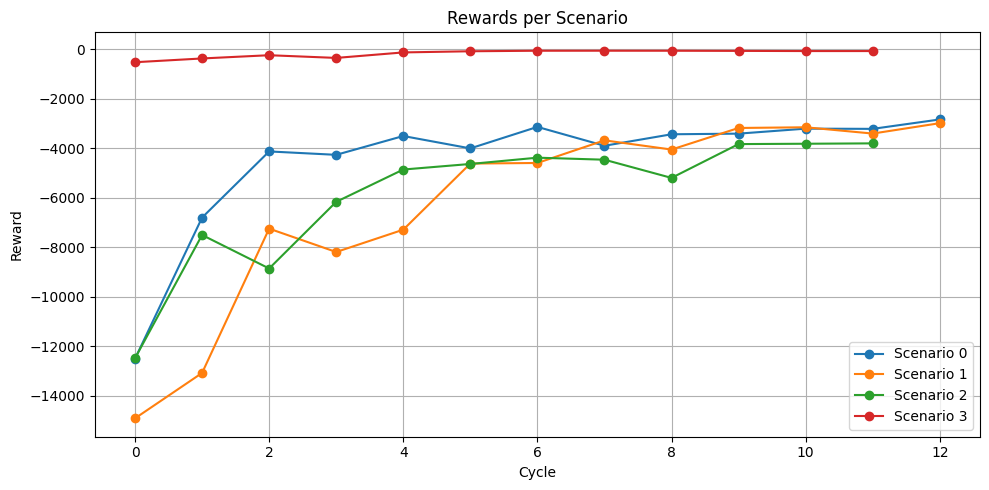

In [ ]:
num_scenarios = 4

# Split the series into 4 separate lists
scenario_rewards = [[] for _ in range(num_scenarios)]
for i, reward in enumerate(rewards_per_episode):
    scenario_rewards[i % num_scenarios].append(reward)

# Plot each scenario as a separate line
plt.figure(figsize=(10, 5))
for i in range(num_scenarios):
    plt.plot(scenario_rewards[i], marker='o', label=f'Scenario {i}')

plt.xlabel('Cycle')
plt.ylabel('Reward')
plt.title('Rewards per Scenario')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
